In [41]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import matplotlib 
from sqlalchemy import create_engine
from sshtunnel import SSHTunnelForwarder
import pickle
from scipy import stats
idx = pd.IndexSlice
%matplotlib inline 

In [42]:
''' 
bitconnect to the database 
'''
def get_db_connection():
    username = 'mig'
    password = 'password' 
    host_name = 'localhost'
    port = 5432
    db_name = 'mtg'
    conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host_name, port, db_name)

    engine = create_engine(conn_str)
    return engine

In [43]:
def get_db_connection_ssh(local = False):
    
    '''
    close connections by doing 

    engine.dispose()
    server.close()
    '''
    
    server_host = '192.168.1.8' if local == True else 'mtgdata.ddns.net'
    server = SSHTunnelForwarder(
         (server_host, 49000),
         ssh_password="red",
         ssh_username="mig",
         remote_bind_address=('127.0.0.1', 5432)
    )

    server.start()

    username = 'mig'
    password = 'password' 
    host_name = 'localhost'
    port = server.local_bind_port # assigned local port
    db_name = 'mtg'
    conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host_name, port, db_name)

    engine = create_engine(conn_str)
    
    return engine, server

In [44]:
#fix the ts
def correct_ts(ts):
    minute = 0 if ts.minute < 30 else 30
    ts_corrected = pd.Timestamp(ts.year, ts.month, ts.day, ts.hour, minute)
    return ts_corrected

def data_transformer(df):
    df = df.copy()
    df.ts = df.ts.map(correct_ts)
    df = df.set_index(['ts', 'card_name'])
    df = df.sort_index(level=['ts', 'card_name'])
    return df

In [45]:
'''
read the records
'''

now = pd.Timestamp.now(tz='UTC').date()
now_minus_24_hours = now - pd.Timedelta('%d hours'%(24,))
engine, server = get_db_connection_ssh(local=True)

query = '''
SELECT *  
FROM card_listings;
'''#%(str(now_minus_24_hours), str(now))

df_db = pd.read_sql_query(query, engine)
engine.dispose()
server.close()

In [46]:
df_db.dtypes

card_name                         object
ts                        datetime64[ns]
seller_name                       object
seller_sales                       int64
seller_available_items             int64
item_price                       float64
item_amount                        int64
item_location                     object
item_condition                    object
item_language                     object
item_is_playset                     bool
item_is_foil                        bool
avg_sell_price                   float64
dtype: object

In [47]:
df = data_transformer(df_db)
df

seller_name  seller_sales  \
ts                  card_name                                         
2019-10-10 16:30:00 Snow Covered Island     toycastle          3357   
                    Snow Covered Island     talcoon85          1223   
                    Snow Covered Island      greggoss           716   
                    Snow Covered Island      svilla92           282   
                    Snow Covered Island   Soldatpacif           170   
...                                               ...           ...   
2019-10-22 23:30:00 Snow Covered Island  BaidiukCards           278   
                    Snow Covered Island  veganjustice             1   
                    Snow Covered Island     Onlycards         22784   
                    Snow Covered Island   Hobby-Games         78299   
                    Snow Covered Island   Hobby-Games         78299   

                                         seller_available_items  item_price  \
ts                  card_name                                                 
2019-10-10 16:30:00 Snow Covered Island                  119435        0.00   
                    Snow Covered Island                      14        0.00   
                    Snow Covered Island                     920        0.00   
                    Snow Covered Island                      24        0.00   
                    Snow Covered Island                      47        0.00   
...                                                         ...         ...   
2019-10-22 23:30:00 Snow Covered Island                    1209       39.99   
                    Snow Covered Island                     492       39.99   
                    Snow Covered Island                   86135       99.00   
                    Snow Covered Island                 1545751       99.99   
                    Snow Covered Island                 1545751      299.99   

                                         item_amount item_location  \
ts                  card_name                                        
2019-10-10 16:30:00 Snow Covered Island            1                 
                    Snow Covered Island            2                 
                    Snow Covered Island            1                 
                    Snow Covered Island            1                 
                    Snow Covered Island            1                 
...                                              ...           ...   
2019-10-22 23:30:00 Snow Covered Island            1       Austria   
                    Snow Covered Island            2       Germany   
                    Snow Covered Island            8         Spain   
                    Snow Covered Island            8        Greece   
                    Snow Covered Island            8        Greece   

                                        item_condition item_language  \
ts                  card_name                                          
2019-10-10 16:30:00 Snow Covered Island             NM       English   
                    Snow Covered Island             NM       English   
                    Snow Covered Island             NM        French   
                    Snow Covered Island             NM       Spanish   
                    Snow Covered Island             NM        French   
...                                                ...           ...   
2019-10-22 23:30:00 Snow Covered Island             NM       Russian   
                    Snow Covered Island             NM       English   
                    Snow Covered Island             NM       English   
                    Snow Covered Island             NM       English   
                    Snow Covered Island             NM       English   

                                         item_is_playset  item_is_foil  \
ts                  card_name                                            
2019-10-10 16:30:00 Snow Covered Island            False         False   
                    

In [57]:
'''
plot item_amount per card condition
'''
def plot_item_amount_per_card_condition(card_name, df):

    df_card_name = df.xs(card_name, level='card_name', drop_level=True)
    index = pd.date_range(start=df_card_name.index[0], end=df_card_name.index[-1], freq='30min')
    index.name = 'ts'
    dfs = []
    title = card_name + ' Item Amount per Card Condition'
    for condition in df.item_condition.unique():
        #we need to generate data with item_amount=0 for the periods in which card_conditions are not represented
        df_condition_dummy = pd.DataFrame([(condition, 0) for i in index], 
            index=index, columns=['item_condition', 'item_amount']).\
            append(df_card_name.loc[df_card_name.item_condition == condition]).sort_index()
        df_condition_plot = df_condition_dummy.item_amount.\
            groupby(level='ts').sum()
        df_condition_plot.plot(figsize=(16, 4), rot=20, label=condition) 
        # create column before inserting in the list
        df_condition_plot = df_condition_plot.to_frame()
        df_condition_plot['item_condition'] = condition

        dfs.append(df_condition_plot)

    df_all_plot = pd.DataFrame([(np.nan, 0) for i in index], \
            index=index, columns=['item_condition', 'item_amount']).\
            append(df_card_name).sort_index().\
            item_amount.groupby(level='ts').sum()
    df_all_plot.plot(figsize=(16, 4), rot=20, title=title, label= 'All')  
    # create column before inserting in the list
    df_all_plot = df_all_plot.to_frame()
    df_all_plot['item_condition'] = 'All'

    dfs.append(df_all_plot)

    dfs_concatenated = pd.concat(dfs, axis=0)

    plt.legend();
    
    # save the dfs 
    card_name = card_name.replace('/', '').replace(',', '').replace('  ', '_').replace(' ', '_')
    with open(card_name + '_stock.pickle', 'wb') as handle:
        pickle.dump(dfs_concatenated, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    '''
    # save the dfs 
    with open('dfs.pickle', 'wb') as handle:
        pickle.dump(dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('dfs_concatenated.pickle', 'wb') as handle:
        pickle.dump(dfs_concatenated, handle, protocol=pickle.HIGHEST_PROTOCOL)
    dfs = None
    dfs_concatenated = None

    with open('dfs.pickle', 'rb') as handle:
        dfs = pickle.load(handle)
    with open('dfs_concatenated.pickle', 'rb') as handle:
        dfs_concatenated = pickle.load(handle)

    display(dfs_concatenated.head())
    display(dfs[0].head())
    
    #tabela com: 
    #columns: ts, quantidade, card condition
    '''

In [58]:
def plot_item_price_distribution(ts, card_name):    
    '''
    example ts = '2019-10-17 00:00:00'
    '''
    
    plot_settings = { # 'card_name: (bin_span, z_threshold)
        'Snow Covered Island': (.1, 0.5), 
        'Oko, Thief of Crowns': (1, 3), 
        'Fabled Passage': (.5, 2), 
        'Once Upon a Time': (.5, 3), 
        'Murderous Rider // Swift End': (.5, 3), 
        'Questing Beast': (.5, 3), 
    }
    
    df_instant = df.loc[idx[ts, card_name], ['item_price', 'item_amount']].\
        set_index('item_price')
    bin_span = plot_settings[card_name][0] # range of a bin
    z_threshold = plot_settings[card_name][1] # how much distance measured in z_threshold * standard deviations will i allow my values to have from the mean

    # remove outliers - values that are further than 3 * standard deviation from the mean
    df_instant = df_instant[(np.abs(stats.zscore(df_instant.index)) < z_threshold)]
    # bin the values
    df_instant_binned = df_instant.\
        groupby(pd.cut(df_instant.index, np.arange(0, df_instant.index.max() + bin_span, bin_span))).sum()

    ax = df_instant_binned.plot.bar(figsize=(16, 4), rot=45)

    # fix axis
    n = 4 # this value should be ajusted according to the number of listings
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]  # <---- blearghk!!
    ax.xaxis.set_ticks(ticks[::n])
    ax.xaxis.set_ticklabels(ticklabels[::n])
    plt.xlabel('item_price')
    plt.ylabel('item_amount')
    plt.title(card_name + ' price distribution at ' + ts)
    
    plt.legend()

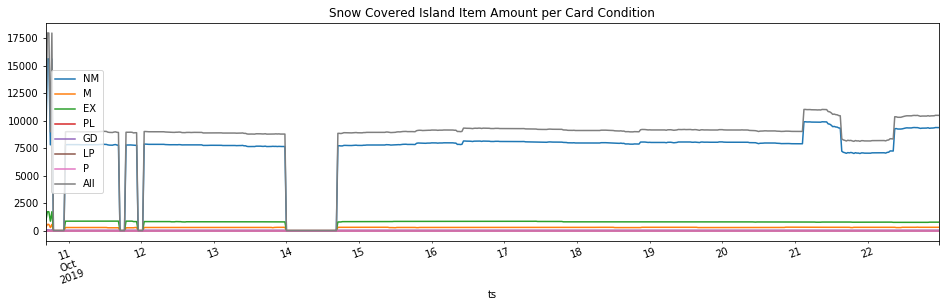

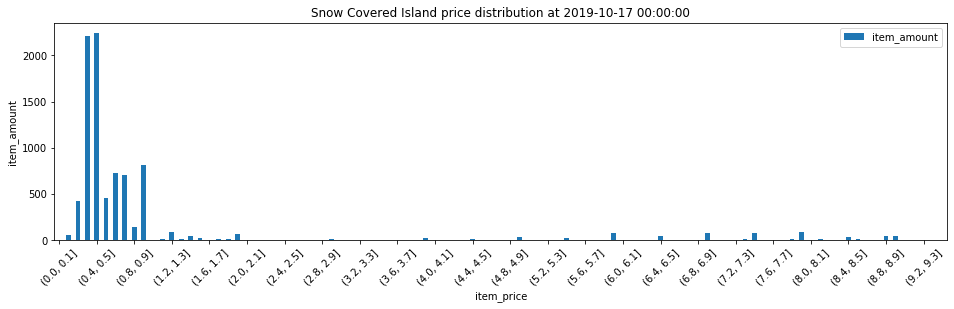

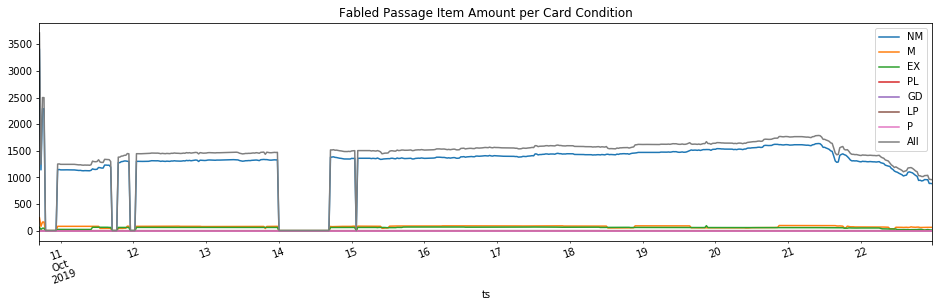

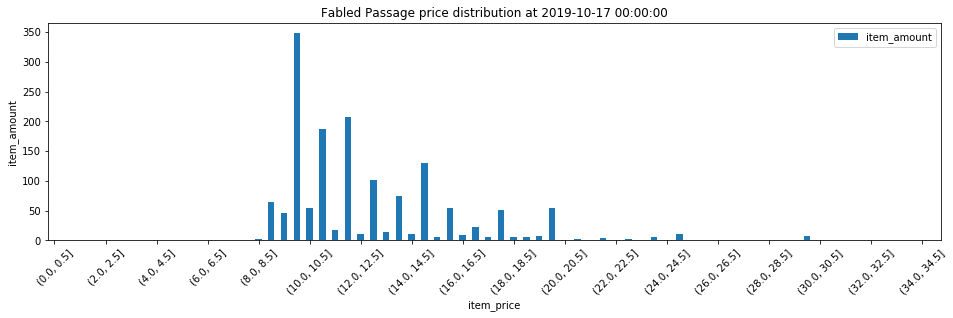

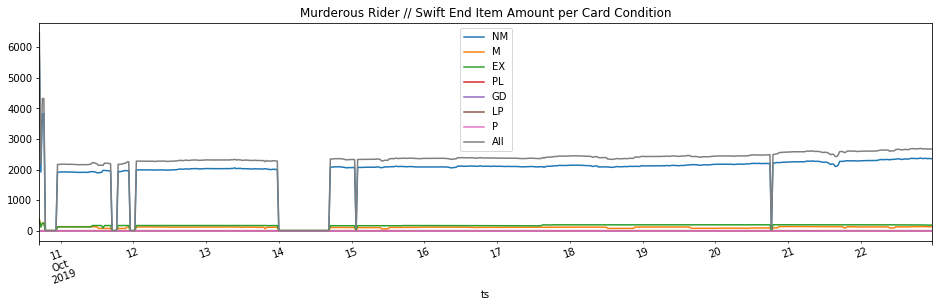

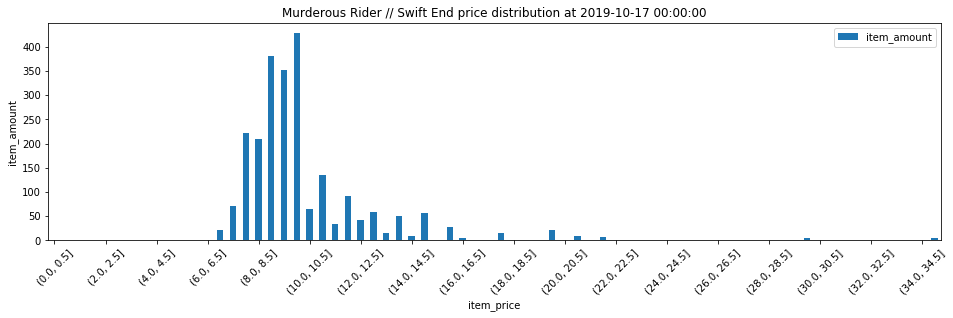

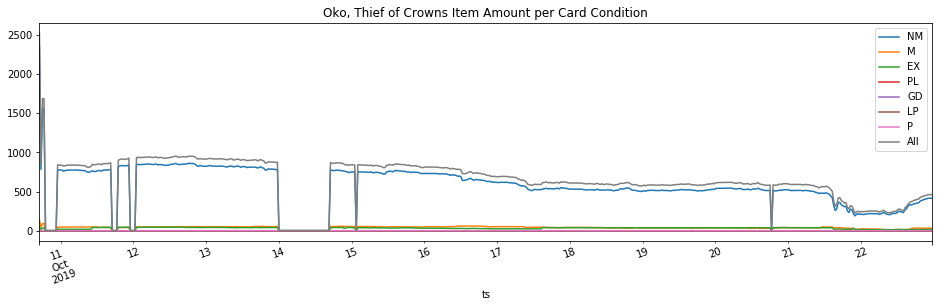

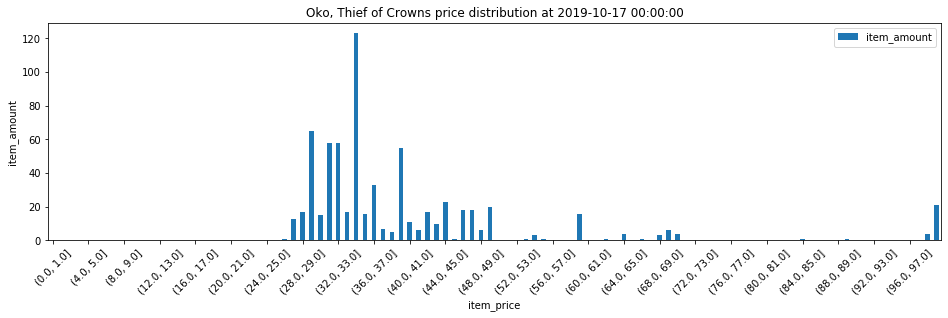

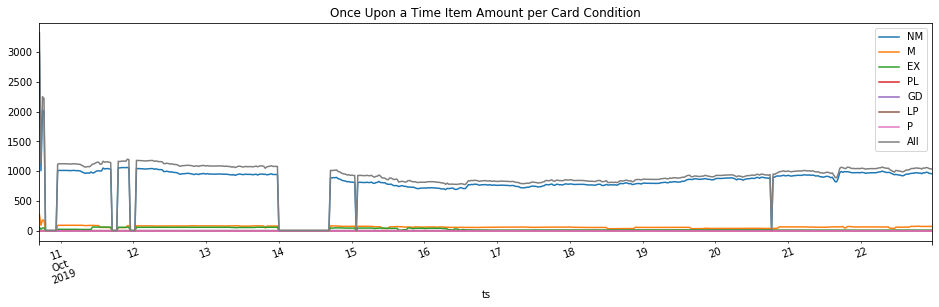

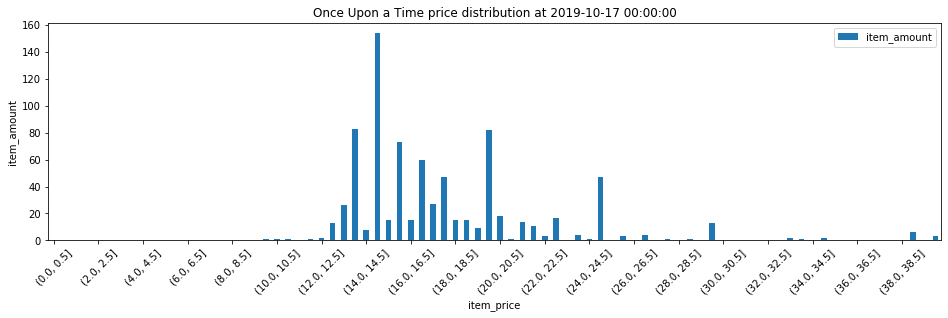

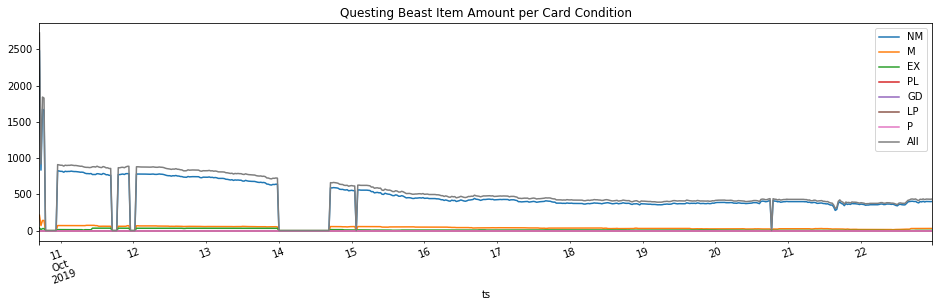

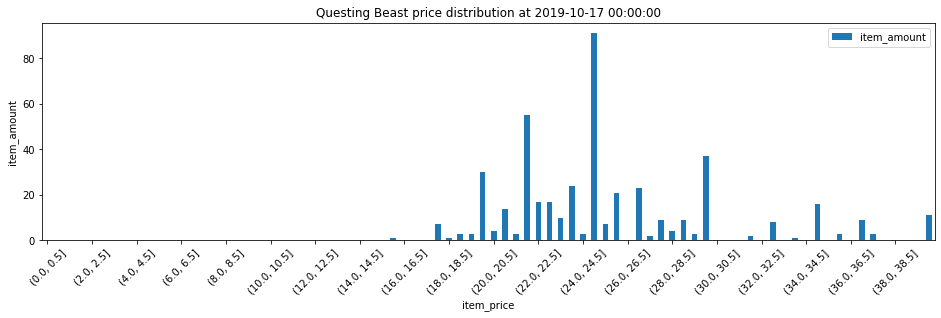

In [59]:
ts = '2019-10-17 00:00:00'

# item_amount
for card_name in df.index.get_level_values('card_name').unique():
    
    # item amount per card condition
    plot_item_amount_per_card_condition(card_name, df)
    
    # item_price_distribution for a given ts
    plot_item_price_distribution(ts, card_name)
        
    plt.show();

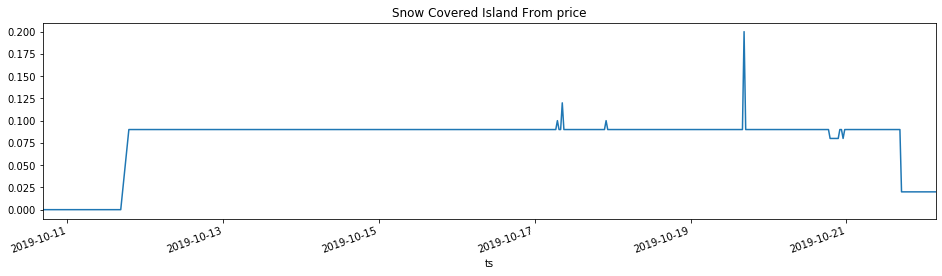

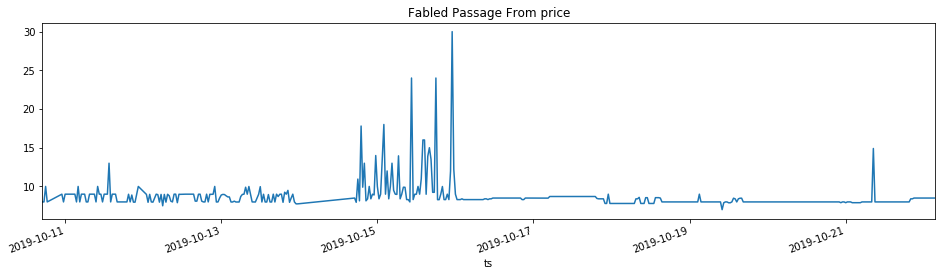

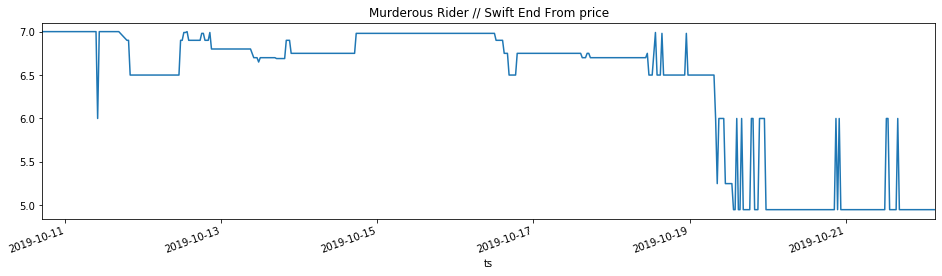

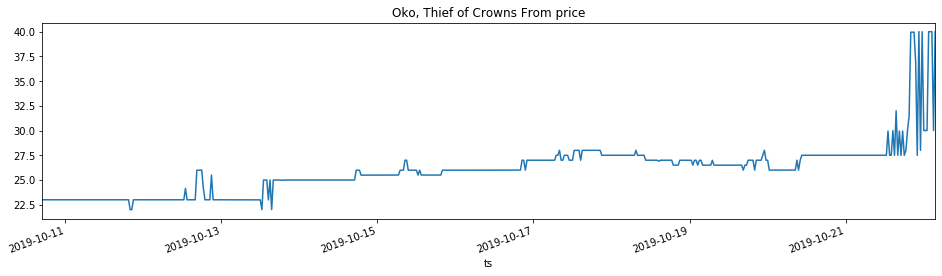

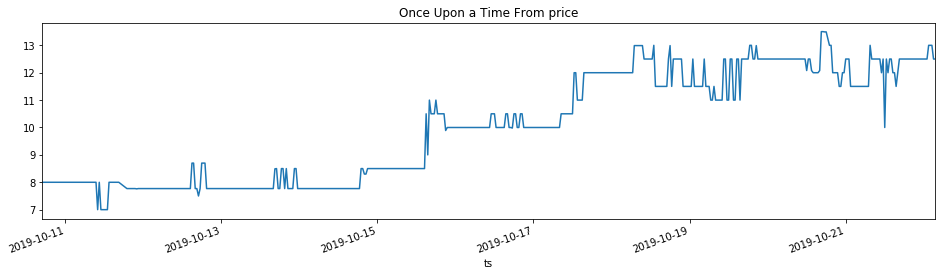

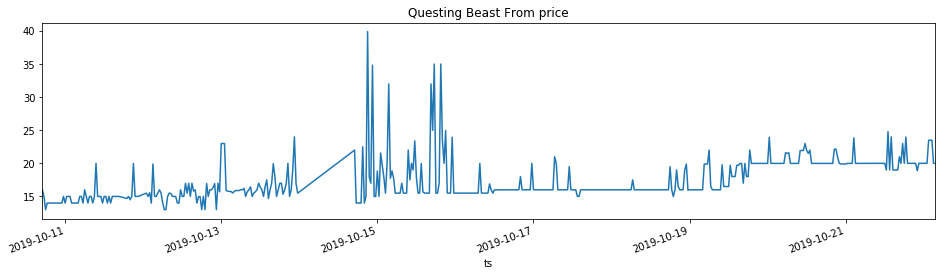

In [21]:
# From price
for card_name in df.index.get_level_values('card_name').unique():
    df.xs(card_name, level='card_name', drop_level=True).\
        groupby(level='ts').first().item_price.plot(figsize=(16, 4), rot=20, title='%s From price' % card_name)
    plt.show()

In [22]:
# item price distribution at a given time slot
card_name = 'Snow Covered Island'
df.xs(card_name, level='card_name', drop_level=True).\
        item_price.unique()

array([0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
       5.0000e+00, 6.0000e+00, 7.0000e+00, 8.0000e+00, 9.0000e+00,
       1.0000e+01, 1.1000e+01, 1.2000e+01, 1.3000e+01, 1.4000e+01,
       1.5000e+01, 1.6000e+01, 1.7000e+01, 1.8000e+01, 1.9000e+01,
       2.0000e+01, 2.2000e+01, 2.4000e+01, 2.5000e+01, 3.0000e+01,
       3.4000e+01, 3.8000e+01, 4.0000e+01, 1.0000e+02, 3.0000e+02,
       6.0000e+02, 9.0000e-02, 1.0000e-01, 1.1000e-01, 1.2000e-01,
       1.5000e-01, 1.8000e-01, 1.9000e-01, 2.0000e-01, 2.2000e-01,
       2.3000e-01, 2.4000e-01, 2.5000e-01, 2.7000e-01, 2.7500e-01,
       2.8000e-01, 2.9000e-01, 2.9750e-01, 3.0000e-01, 3.2000e-01,
       3.3000e-01, 3.4000e-01, 3.5000e-01, 3.6000e-01, 3.7000e-01,
       3.7250e-01, 3.7500e-01, 3.8000e-01, 3.9000e-01, 4.0000e-01,
       4.1000e-01, 4.2000e-01, 4.3000e-01, 4.4000e-01, 4.5000e-01,
       4.6000e-01, 4.7000e-01, 4.7250e-01, 4.8000e-01, 4.8250e-01,
       4.8750e-01, 4.9000e-01, 5.0000e-01, 5.1000e-01, 5.4000e

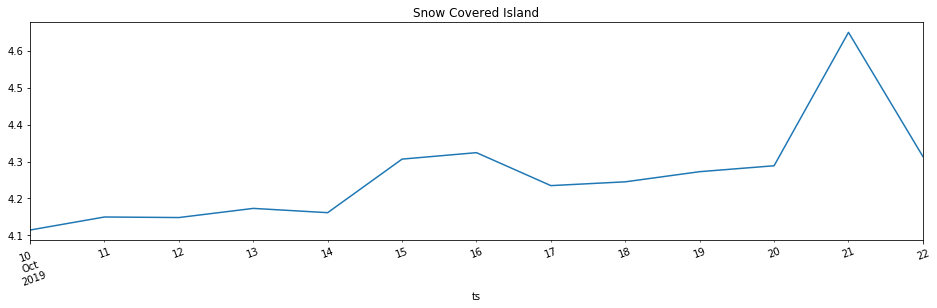

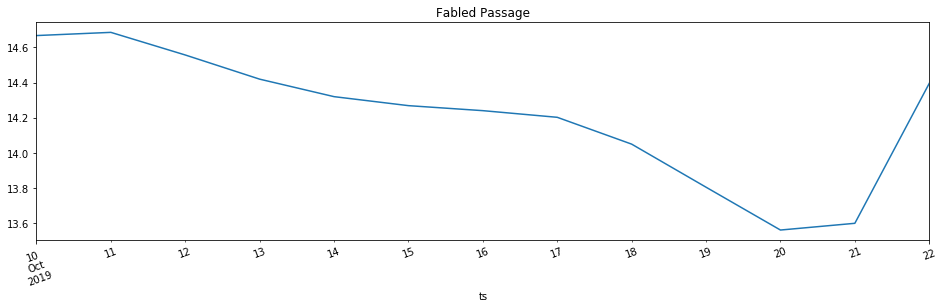

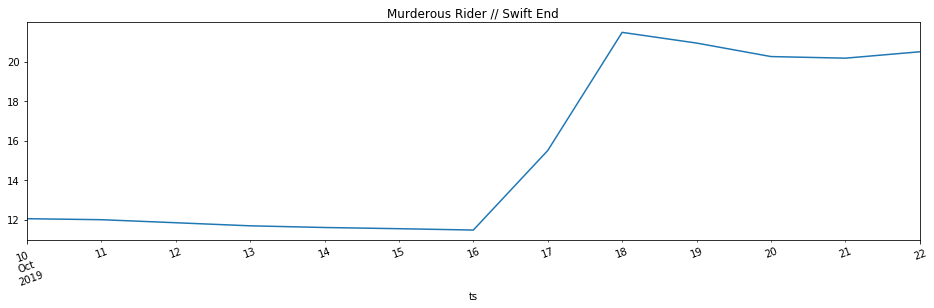

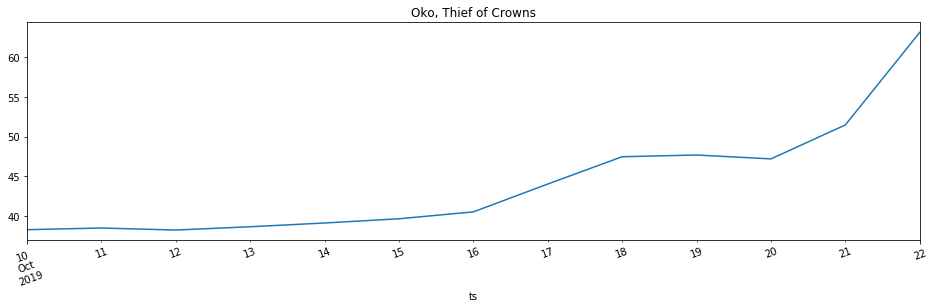

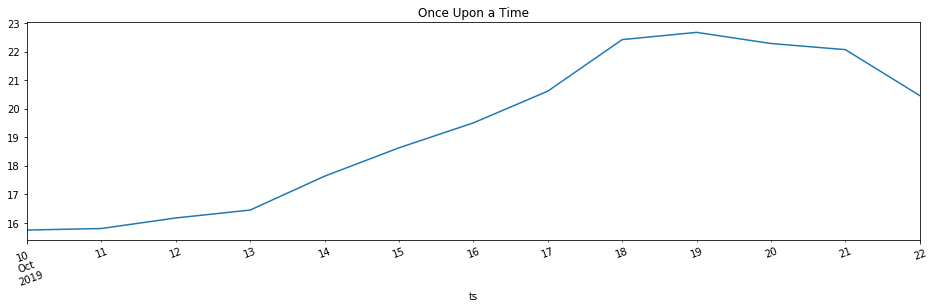

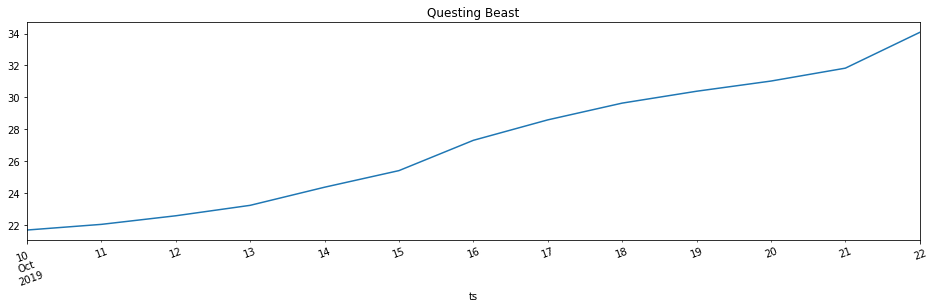

In [23]:
# item price distribution at a given time slot
for card_name in df.index.get_level_values('card_name').unique():
    df.xs(card_name, level='card_name', drop_level=True).\
        item_price.groupby(level='ts').mean().resample('d').mean().plot(figsize=(16, 4), rot=20, title=card_name)
    plt.show();

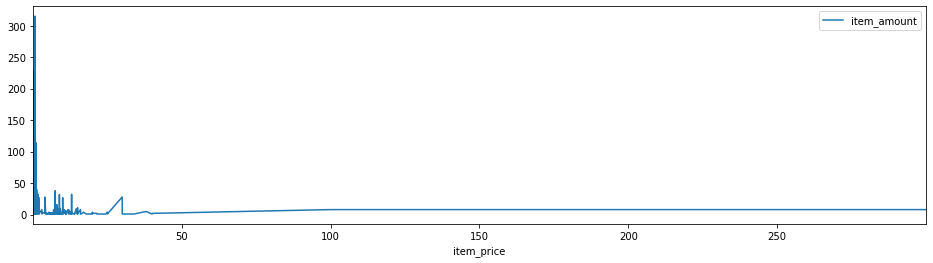

In [24]:
# item_price ordered plot
df.loc[idx['2019-10-13 13:30:00', 'Snow Covered Island'], ['item_price', 'item_amount']].\
    set_index('item_price').iloc[:].plot(figsize=(16, 4), rot=0)

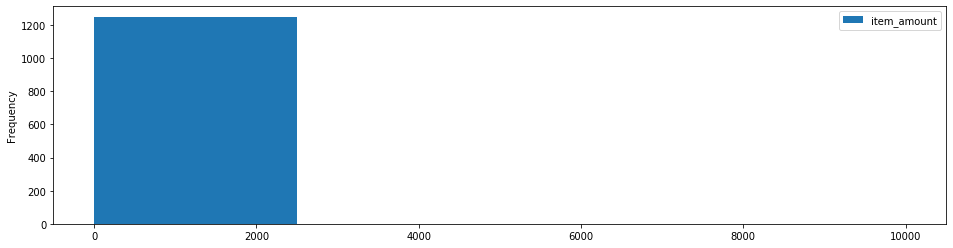

In [25]:
# item_price ordered plot
bins = np.linspace(df.item_price.min(), df.item_price.max(), num=5)
df.loc[idx['2019-10-13 13:30:00', 'Snow Covered Island'], ['item_price', 'item_amount']].\
    set_index('item_price').iloc[:].plot.hist(bins=bins, figsize=(16, 4), rot=0)

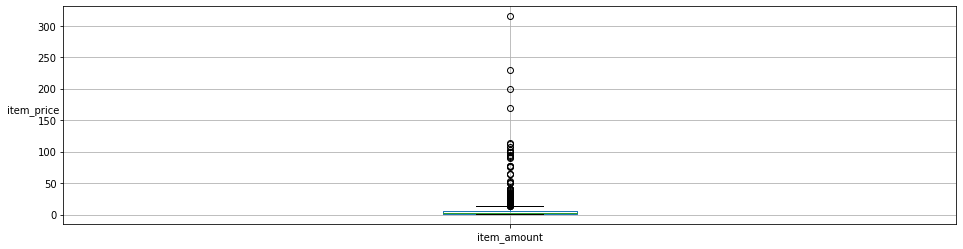

In [26]:
# item_price ordered plot
bins = np.linspace(df.item_price.min(), df.item_price.max(), num=5)
df.loc[idx['2019-10-13 13:30:00', 'Snow Covered Island'], ['item_price', 'item_amount']].\
    set_index('item_price').iloc[:].boxplot(figsize=(16, 4), rot=0)
#plt.xlabel('xlabel', fontsize=18)
plt.ylabel('item_price', rotation=.0000001)
#plt.ylabel(rotation=45)
plt.show()

In [27]:
df.loc[idx['2019-10-13 13:30:00', 'Snow Covered Island'], ['item_price', 'item_amount']].\
    set_index('item_price')

,item_amount
item_price,
0.09,1
0.09,2
0.09,1
0.10,1
0.10,1
...,...
38.00,5
39.99,1
39.99,2


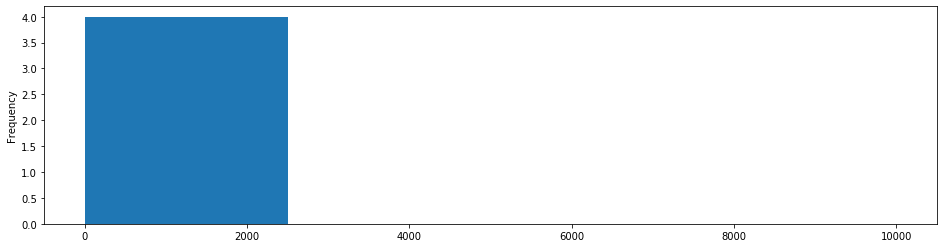

In [28]:
'''
bins = [0,0.35,0.7,1]
df = df.groupby(pd.cut(df['val'], bins=bins)).val.count()
df.plot(kind='bar')
'''

q = df["item_price"].quantile(0.80)
bins = np.linspace(df.item_price.min(), df.item_price.max(), num=5)

df_distribution = df[df["item_price"] < q].\
    loc[idx['2019-10-13 13:30:00', 'Snow Covered Island'], ['item_price', 'item_amount']].\
    reset_index(drop=True)

#'''
df_distribution.\
    groupby(pd.cut(df_distribution.item_price, bins=bins)).item_price.count().\
    plot.hist(bins=bins, figsize=(16, 4), rot=0)
    
#'''
#df_distribution

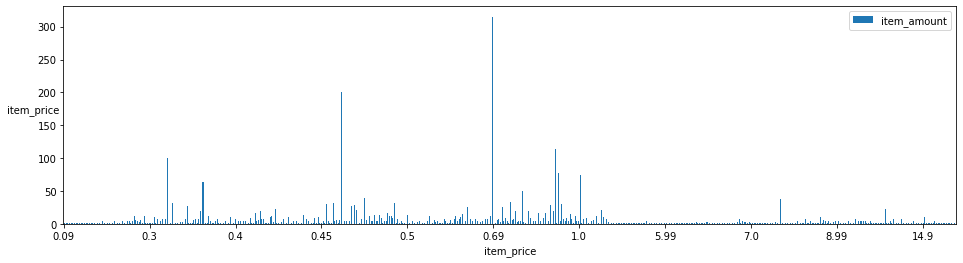

In [29]:
q = df["item_price"].quantile(0.95)
# our actual chart 
ax = df[df["item_price"] < q].loc[idx['2019-10-13 13:30:00', 'Snow Covered Island'], ['item_price', 'item_amount']].\
    set_index('item_price').iloc[:].plot(kind='bar', figsize=(16, 4), rot=0)


# this fixes the axis. 
# I wouldn't spend too much time in this horrible Matplotlib code, just know it exists. 

n = 120
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]  # <---- blearghk!!
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])
plt.ylabel('item_price', rotation=.0000001)
plt.show()

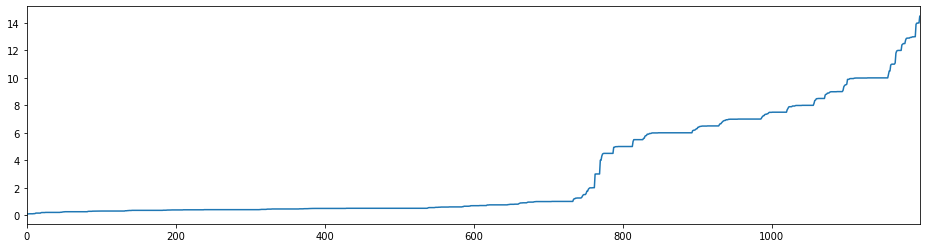

In [30]:
# item_price, first 100 items
df.loc[idx['2019-10-13 13:30:00', 'Snow Covered Island'], 'item_price'].\
    reset_index(drop=True).iloc[:1200].plot(figsize=(16, 4), rot=0)

In [31]:
df_xs = df.xs('Snow Covered Island', level='card_name', drop_level=True)

In [32]:
df_xs.loc['2019-10-13 13:30:00', 'item_amount'].sum()

8772

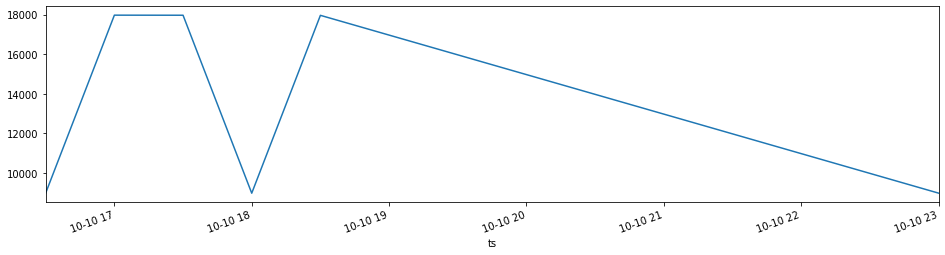

In [33]:
df_plot = df_xs.loc[:'2019-10-10 23:00:00', 'item_amount']
df_plot.groupby(df_plot.index).sum().plot(figsize=(16, 4), rot=20); 